# INFO-4604 HW4 Part B: Sentiment Classification 

* Created by Michael Paul on October 28, 2017
* Modified by Matt Kaiser on Nov,6 with Tanner Quigly and Alex Bozanic

##### Deadline: Monday, November 6, 8:00pm MT

In this assignment, you will classify the *sentiment* of tweets (positive, negative, or neutral), using the data that was annotated in Part A. The main goal of this assignment is to get practice with feature engineering, feature extraction, and feature selection.

### What to hand in

You will submit the assignment on Piazza. A private note to the instructor should be submitted with the subject _"Submission 4 from [your full name]"_ with the submission file(s) as an attachment. The note should be submitted to the `submissions` folder (**not** the `hw4` folder).

This time, there are three files to submit:

- A Jupyter notebook named `hw4lastname.ipynb`, where lastname is replaced with your last name.
- A CSV file named `hw4lastname_predictions_cv.csv` (see Deliverable 2.3).
- A CSV file named `hw4lastname_predictions_test.csv` (see Deliverable 2.3).


### Submission policies

- **Collaboration:** You are allowed to work with up to 3 people besides yourself. You are still expected to write up your own solution. Each individual must post their own submission on Piazza, and you must list the names of your group members in your Piazza note when you submit.
- **Late submissions:** We allow each student to use up to 5 late days over the semester. You have late days, not late hours. This means that if your submission is late by any amount of time past the deadline, then this will use up a late day. If it is late by any amount beyond 24 hours past the deadline, then this will use a second late, and so on. Once you are out of late days, you can receive no more than 80% credit for an assignment that is up to one day late, and no more than 60% credit for an assignment that is more than one day late. 

### Asking for help

You are encouraged to ask questions on [Piazza](https://piazza.com/colorado/fall2017/info4604). Do not post anything that you are turning in, but you can describe general things you observe about the algorithms. You may ask questions to help with debugging, but do not post your code. You can share error messages and describe what you are trying to do with your code, but try not to write enough to "give away" the solution.

Questions specifically about this assignment should be posted in the `hw4` folder. If you have clarifications about what is being asked, you can tag the instructor in your post. If you have more general programming questions (for example, if you are having trouble installing packages, running the notebook, or working with `numpy`), post in the `python` folder. (You can post in multiple folders if both are relevant.)


## Annotated data

In Part A of this assignment, everyone annotated a subset of tweets (between 100 and 250 tweets per person) for sentiment toward the 2017 movie, _Geostorm_. Sentiment labels could be one of three classes (positive, negative, neutral). Each tweet was labeled as:

- **1:** The tweet expresses a *positive* opinion toward the movie (for example, the user saw it and enjoyed it, or has not seen it but wants to).
- **0:** The tweet is either irrelevant, does not express an opinion, or expresses an opinion that is mixed or unclear.
- **-1:** The tweet expresses a *negative* opinion toward the movie (for example, the user saw it and did not like it, or does not want to see it).

In this assignment, Part B, we will build classifiers to predict these three classes.


### Summary of Part A results

In Part A, each person's 250 tweets were randomly selected from a larger set of tweets. This was done so that most tweets were annotated by multiple people (though the number of people per tweet varied due to the randomness). This allows us to see how well people agreed on the correct annotations, and use this to decide on a final label.

Here are the results. A total of 2021 tweets had annotations from at least two people. Of those, 1724 tweets had a label that was agreed on by at least 50% of the annotators, 1359 tweets had a majority label agreed on by at least 75% of the annotators, and there were 1044 tweets where 100% of annotators agreed on the same label. These results show that there was fairly high ambiguity in the data, and annotators often disagreed on the correct label.

Note that not all labels were equally confusing. Of tweets that were given mixed labels by annotators, 622 tweets were given both "positive" and "neutral" labels, 402 were given both "negative" and "neutral" labels, and 223 were given both "positive" and "negative" labels. These numbers show that annotators were less likely to disagree on whether a tweet was positive vs negative than they were to disagree on whether something was neutral vs not neutral.

### Creating data for Part B

To create an annotated dataset for this assignment, the following rule was used. In order to ensure accurate labels, we only used tweets where at least 90% of annotators agreed on the label. 1046 tweets met this criterion.

The dataset has been prepared for you. A random subset (approximately 10% of the tweets) was selected as test data, while the rest will be used for training. Run the code below to download and extract the data.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('http://cmci.colorado.edu/classes/INFO-4604/data/hw4_tweets_labeled.csv', 
                 header=None, encoding='ISO-8859-1')

df_train = df.loc[df[0] == 'train']
df_test = df.loc[df[0] == 'test']

Y_train = df_train.iloc[0:, 1].values
text_train = df_train.iloc[0:, 2].values

Y_test = df_test.iloc[0:, 1].values
text_test = df_test.iloc[0:, 2].values

## Setting up the classifier

### Tokenization and feature extraction

The first step is to convert the raw text into feature vectors. In Ch. 8 of the book, the class [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) is presented as a way to convert text strings into `sklearn` feature vectors. This class can automatically perform tokenization (doing preprocessing steps we talked about in class, including lowercasing and stripping punctuation). However, for this assignment, we aren't going to use `CountVectorizer`, though it is useful to know about. We will instead write our own code to do tokenization and feature extraction. This will allow us to modify the features, which you will need to do later, plus it will let you see how feature extraction is done.

The code below defines our feature extraction function, `features`. It takes a text string and it outputs a Python dictionary where the keys are the feature names and the values are the feature values. This is a _sparse_ representation, meaning it only outputs features with nonzero value.

By default, the features extracted by this function are n-gram counts. The keyword argument `ngram_range` specifies the length of n-grams to extract. This argument should be a pair of integers, where the first integer is the lower end of the length to be extracted and the second integer is the upper end. For example, `ngram_range=(1,3)` will extract 1-grams, 2-grams, and 3-grams, while `ngram_range=(2,2)` will extract only 2-grams.

The function performs two initial preprocessing steps: making the text lowercase (so different capitalizations of words will map to the same feature), and removing consecutive characters that are repeated more than twice (e.g., "woooow" and "wooooooooow" will both map to simply "woow" rather than being counted as separate words).

The function tokenizers words as follows. First, non-alphanumeric characters are replaced with whitespace, then strings separated by whitespace are treated as tokens. Python's `split` function converts a string into a list of tokens that were separated by whitespace. The list of tokens is passed to the `ngrams` function, defined below, which returns a list of all n-grams of length `n` contained in the list. Finally, the function also pulls out tokens containing anything _but_ alphanumeric characters. This will capture punctuation marks and emojis, which may also be useful for classification. These are treated as unigram features rather than longer sequences.

For now, simply run the code below. However, you'll need to modify this code later, so you need to understand what it is doing.

In [2]:
import re
from collections import Counter

def ngrams(tokens, n):
    output = []
    for i in range(n-1, len(tokens)):
        ngram = ' '.join(tokens[i-n+1:i+1])
        output.append(ngram)
    return output

def features(text, ngram_range=(1,1)):
    text = text.lower()      # make the string lowercase
    text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice
    
    features_in_text = []   # running list of all features in this instance (can be repeated)
    
    # treat alphanumeric characters as word tokens (removing anything else),
    # and extract all n-grams of length n specified by ngram_range
    
    text_alphanum = re.sub('[^a-z0-9]', ' ', text)
    for n in range(ngram_range[0], ngram_range[1]+1):
        features_in_text += ngrams(text_alphanum.split(), n)
    
    # now treat punctuation as word tokens, and get their counts (only unigrams)
    
    text_punc = re.sub('[a-z0-9]', ' ', text)
    features_in_text += ngrams(text_punc.split(), 1)
    
    # 'Counter' converts a list into a dictionary whose keys are the list elements 
    #  and the values are the number of times each element appeared in the list
    
    return Counter(features_in_text)


To get a better understanding of what the `features` function is returning, see what happens on the example text when you run the code below. The `ngram_range` is set to `(1,2)` which means it will extract both 1-grams and 2-grams. You should notice that it extracts all words (separated by punctuation) and two-word phrases, with counts based on how often they appear (e.g., "`a sentence`" is a 2-gram that appears twice). Also note that punctuation is also counted (but only as 1-grams, not 2-grams), and notice that "`!!`" has a count of 2 because "!!!" was rewritten as "!!".

You may find it helpful to change the text and/or the n-gram range to see what features are extracted.

In [3]:
text = "This is an example of a sentence to tokenize!! Actually, it's more than a sentence, it's two sentences!!!"

print(features(text, ngram_range=(1,2)))

Counter({'a': 2, 'sentence': 2, 'it': 2, 's': 2, 'a sentence': 2, 'it s': 2, '!!': 2, ',': 2, "'": 2, 'this': 1, 'is': 1, 'an': 1, 'example': 1, 'of': 1, 'to': 1, 'tokenize': 1, 'actually': 1, 'more': 1, 'than': 1, 'two': 1, 'sentences': 1, 'this is': 1, 'is an': 1, 'an example': 1, 'example of': 1, 'of a': 1, 'sentence to': 1, 'to tokenize': 1, 'tokenize actually': 1, 'actually it': 1, 's more': 1, 'more than': 1, 'than a': 1, 'sentence it': 1, 's two': 1, 'two sentences': 1})


Finally, we need to extract features from all of the training instances and convert them into a feature vector representation to be used by `sklearn`. The code below takes the output of the `features` function (with only 1-grams for this example, though you will change this later), then maps all the feature strings into integers, then defines `X_train` as a sparse array that encodes the values of each feature in each instance. Like in HW2, the [`DictVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) is used to do this conversion. 

In [4]:
from sklearn.feature_extraction import DictVectorizer

vect = DictVectorizer()
X_train1 = vect.fit_transform(features(d, ngram_range=(1,1)) for d in text_train)

In [5]:
from sklearn.feature_extraction import DictVectorizer

vect = DictVectorizer()
X_train2 = vect.fit_transform(features(d, ngram_range=(2,2)) for d in text_train)

In [6]:
from sklearn.feature_extraction import DictVectorizer

vect = DictVectorizer()
X_train3 = vect.fit_transform(features(d, ngram_range=(1,3)) for d in text_train)

### Classifier and hyperparameter tuning

In this assignment, we will use multinomial logistic regression as our classifier. Recall that logistic regression outputs probabilities, and the multinomial version can handle more than two classes. Mulinomial logistic regression is also called a "maximum entropy" or "MaxEnt" classifier.

We will use `sklearn`'s [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class, setting the `multi_class` argument to `'multinomial'` which tells it to use the multinomial version (otherwise it defaults to binary logistic regression with a one-vs-rest scheme for multiclass data).

The `LogisticRegression` class uses the argument `C` to denote the regularization strength (same as in the `SVC` class you used in HW3). It is important to adjust this hyperparameter to get good performance. We will tune this hyperparameter each time we build a classifier, using cross-validation for optimizing `C`. 

`sklearn` has a class, [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for tuning a classifier with cross-validation. When you construct a `GridSearchCV` object, you supply the set of parameters and their possible values that you would like to adjust. During training, it will perform cross-validation with every combination of parameter values, then train a final classifier using the best-performing settings. In our case, we are only tuning one parameter (`C`), so there won't be too many combinations of values to try, though it may still take a minute to run each time.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score

# this defines the classifier we will use -- don't change this variable

base_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=123)

# these are the C values we will compare -- don't change this variable

params = [{'C': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 50.0, 100.0]}]

# this performs 5-fold cross-validation with the above classifier and parameter options

gs_classifier = GridSearchCV(base_classifier, params, cv=5)
gs_classifier.fit(X_train1, Y_train)

print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)

Best parameter settings: {'C': 1.0}
Validation accuracy: 0.731707


In the code above, calling `gs_classifier.fit` will perform cross-validation for all parameter settings. Once it finishes, then `gs_classifier` can be used as any other classifier object, so you can call the `predict` or `predict_proba` functions to make classifications, just as you did in HW3. As you can see in the code above, the object also contains variables that will give you the optimal parameters and cross-validation accuracy.

Throughout this assignment, anytime you are asked to train a classifier, you should do so by calling `GridSearchCV(base_classifier, params, cv=5)` rather than directly calling the `LogisticRegression` class. Whenever you are asked for the cross-validation accuracy, this is given by the `best_score_` variable that you see above.

## Problem 1: Feature Choice and Selection [10 points]

We will begin by experimenting with different feature sets, where we modify the feature set in two ways. First, we will experiment with different sizes of n-grams. Second, we will experiment with automated feature selection.

### N-gram size

As you saw above, the `features` function takes a keyword argument, `ngram_range`, that let's you specify the sizes of n-grams to extract. Experiment with six different ranges of n-gram sizes: (1,1), (2,2), (3,3), (1,2), (1,3), (2,3)

For each n-gram range, you'll need to re-extract and vectorize the features (calling the `features` and `vect.fit_transform` functions, as done above). For each setting, calculate the cross-validation accuracy after using `GridSearchCV` to find the best $C$ value.

#### Deliverable 1.1: Fill in the table below with the cross-validation accuracy when using each range of n-grams.

| N-grams | Validation accuracy | C Value|        
|---------|---------------------|--------|
| (1,1)   |    73.1              |   1.0  |
| (2,2)   |    69.5              |    2.5  |
| (3,3)   |    64.7              |   1.0    |
| (1,2)   |    73.9              |    1.0 |
| (1,3)   |    72.9             |     2.5    |
| (2,3)   |    68.8              |   0.5      |

Couldn't figure out the loop on this one just ran it with the six different N-gram sizes.

#### Deliverable 1.2: Describe what you observe with different length n-grams. When using only one type of n-gram (1, 2, or 3), how does the length affect accuracy? How does using only one size of n-gram (1, 2, or 3) compare to using a range of different sizes (1-2, 1-3, or 2-3)?

When using one type of N-gram 1, 2, or 3 we see a drop on test performance when going from a unigram to a bigram to a trigram.  In 2/3 cases adding a range to our n-gram search increases validation accuaracy.  We can see a decrease in score when looking at trigrams as (1,2) scores better than (1,3), 1 and 2 by themselves score higher than 3, and 2 by itself scores better than (2,3).  The best performance comes when we look at a range but only unigrams and bigrams for this problem.


I just filled in the function above filling in the blanks with different values to test out.  Code for 1.1 above but in (1,2) because that range performed best.


### Feature selection

Selecting a subset of features can improve classifier efficiency and potentially guard against overfitting. However, it can also hurt performance if too many features are removed. We will now experiment with different levels of feature selection.

We will use the [`SelectPercentile`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html) class, which can be used to select features that are within a specified percentile according to a scoring function that ranks the quality of the features. The code below instantiates a `SelectPercentile` object using the [`chi2`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) function, which performs a chi-squared test for measuring the significance of features. The `percentile` argument specifies the percentile of features that are selected after ranking by their chi-squared statistic. If `percentile=1`, only the top 1% of features will be selected. If `percentile=100`, all features will be selected.

Once you've created a `SelectPercentile` object, its `fit` function can be called to calculate the significance of the features, and its `transform` function will modify the feature vectors to choose only the selected features. The `fit_transform` function performs both of these steps, which is what you see below.

Experiment with different feature selection percentiles to see how the accuracy is affected by different settings.

#### Deliverable 1.3: Calculate the cross-validation accuracy at different values of `percentile`, when the percentile is each of $[1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]$. Create a plot where the percentile is on the x-axis and the accuracy is on the y-axis. Do this for three different classifiers, using n-gram ranges of (1,1), (2,2), and (1,3). You can either create three different figures for these three n-gram ranges, or create one figure with three lines (clearly labeled).

below

#### Deliverable 1.4: Describe what you observe in the 1.3 plots. Comment on any general patterns that you see across all of the plots, and explain why you think this behavior happens. Additionally, comment on any differences in the patterns between the three different classifiers. If there are any differences, what do you think explains the differences?

From graphing the 3 methods together we see similar patterns in performance as we increase our percentile of data tested.  I noticed that 1,1 performs the best once we test more than about 30% of the data as a small n-gram may get confused on small data sets but a longer range such as 1,3 can create some context for itself.  The 1,1 performs the best overall once it has a larger corpus of data involved and overall proves to be the best accuracy for n-grams we test.


In [8]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectPercentile, chi2

# example: feature selection at the 60th percentile.
# Note the renaming of the feature vectors to X_train_selected
P= [1,2,5,10,20,30,40,50,60,70,80,90,100]

train = []
for p in P:
    print ("% iterations...")
    selection = SelectPercentile(percentile= p, score_func=chi2)
    X_train_selected = selection.fit_transform(X_train1, Y_train)
    gs_classifier.fit(X_train_selected, Y_train)
    print("percent: " , p)
    score = gs_classifier.best_score_
    train.append(score)
    print("Validation accuracy: %0.6f" % score)

% iterations...
percent:  1
Validation accuracy: 0.660657
% iterations...
percent:  2
Validation accuracy: 0.703075
% iterations...
percent:  5
Validation accuracy: 0.745493
% iterations...
percent:  10
Validation accuracy: 0.749735
% iterations...
percent:  20
Validation accuracy: 0.750795
% iterations...
percent:  30
Validation accuracy: 0.752916
% iterations...
percent:  40
Validation accuracy: 0.742312
% iterations...
percent:  50
Validation accuracy: 0.753977
% iterations...
percent:  60
Validation accuracy: 0.751856
% iterations...
percent:  70
Validation accuracy: 0.751856
% iterations...
percent:  80
Validation accuracy: 0.748674
% iterations...
percent:  90
Validation accuracy: 0.751856
% iterations...
percent:  100
Validation accuracy: 0.731707


In [9]:
train1 = []
for p in P:
    print ("% iterations...")
    selection = SelectPercentile(percentile= p, score_func=chi2)
    X_train_selected = selection.fit_transform(X_train2, Y_train)
    gs_classifier.fit(X_train_selected, Y_train)
    print("percent: " , p)
    score1 = gs_classifier.best_score_
    train1.append(score1)
    print("Validation accuracy: %0.6f" % score1)

% iterations...
percent:  1
Validation accuracy: 0.658537
% iterations...
percent:  2
Validation accuracy: 0.706257
% iterations...
percent:  5
Validation accuracy: 0.737010
% iterations...
percent:  10
Validation accuracy: 0.743372
% iterations...
percent:  20
Validation accuracy: 0.729586
% iterations...
percent:  30
Validation accuracy: 0.709438
% iterations...
percent:  40
Validation accuracy: 0.708378
% iterations...
percent:  50
Validation accuracy: 0.714740
% iterations...
percent:  60
Validation accuracy: 0.714740
% iterations...
percent:  70
Validation accuracy: 0.718982
% iterations...
percent:  80
Validation accuracy: 0.720042
% iterations...
percent:  90
Validation accuracy: 0.724284
% iterations...
percent:  100
Validation accuracy: 0.694592


In [10]:
train2 = []
for p in P:
    print ("% iterations...")
    selection = SelectPercentile(percentile= p, score_func=chi2)
    X_train_selected = selection.fit_transform(X_train3, Y_train)
    gs_classifier.fit(X_train_selected, Y_train)
    print("percent: " , p)
    score2 = gs_classifier.best_score_
    train2.append(score2)
    print("Validation accuracy: %0.6f" % score2)

% iterations...
percent:  1
Validation accuracy: 0.751856
% iterations...
percent:  2
Validation accuracy: 0.768823
% iterations...
percent:  5
Validation accuracy: 0.767762
% iterations...
percent:  10
Validation accuracy: 0.765642
% iterations...
percent:  20
Validation accuracy: 0.758218
% iterations...
percent:  30
Validation accuracy: 0.748674
% iterations...
percent:  40
Validation accuracy: 0.734889
% iterations...
percent:  50
Validation accuracy: 0.742312
% iterations...
percent:  60
Validation accuracy: 0.743372
% iterations...
percent:  70
Validation accuracy: 0.732768
% iterations...
percent:  80
Validation accuracy: 0.744433
% iterations...
percent:  90
Validation accuracy: 0.747614
% iterations...
percent:  100
Validation accuracy: 0.729586


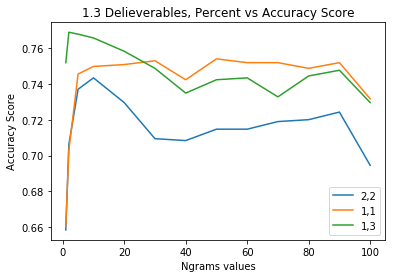

In [11]:
import matplotlib.pyplot as plt
plt.title("1.3 Delieverables, Percent vs Accuracy Score")
plt.xlabel("Ngrams values")
plt.ylabel("Accuracy Score")
plt.plot(P, train1, label = "2,2")
plt.plot(P, train, label = "1,1")
plt.plot(P, train2, label = "1,3")
plt.legend()
plt.show()

## Problem 2: Feature Engineering [7 points; +4 EC possible]

### Choosing final hyperparameters

Above, you experimented with various ranges of n-grams and feature selection percentiles. For the remainder of this assignment, you should stick with one setting of n-gram range and percentile.

Rather than picking the optimal settings, you are going to randomly choose from four different n-gram ranges and five different percentile values. Run the code below to randomly choose what settings you should use.

Why choose randomly? I want everyone in the class to create a slightly different classifier, so that the predictions you submit (below) aren't all identical. Then we'll be able to compare what the different classifiers learned.


In [12]:
import random

ngr = random.choice([(1,1), (1,2), (2,2), (1,3)])
print("Selected n-gram range:", ngr)

per = random.choice([60, 70, 80, 90, 100])
print("Selected percentile:", per)

Selected n-gram range: (1, 3)
Selected percentile: 70


Be sure to continue using the n-gram and percentile values selected above for the rest of Problem 2, even though the settings might result in worse accuracy than what you observed in Problem 1.

Since we are no longer tuning the hyperparameters, now is a reasonable time to also look at the test data. The code below calculates both the cross-validation as well as the accuracy on the test data using the best classifier from cross-validation, using the randomly chosen n-gram and percentile settings. 

You don't need to do anything in this section except understand and run the code in the cell below.

In [13]:
X_train_final = vect.fit_transform(features(d, ngram_range=ngr) for d in text_train)
X_test_final = vect.transform(features(d, ngram_range=ngr) for d in text_test)

selection = SelectPercentile(percentile=per, score_func=chi2)
X_train_final = selection.fit_transform(X_train_final, Y_train)
X_test_final = selection.transform(X_test_final)

gs_classifier = GridSearchCV(base_classifier, params, cv=5)
gs_classifier.fit(X_train_final, Y_train)

print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test_final)))

Validation accuracy: 0.732768
Test accuracy: 0.747573


### Creating new features

You will now expand the feature set by implementing a new type of feature. You get to choose which type of feature to implement, from a set of three possibilities described below.

- **4604 students:** You must implement one of the three types of features for full credit. You will earn 2 extra credit points for each additional type of feature that you correctly implement (up to 4 EC points possible).
- **5604 students:** You must implement two of the three types of features for full credit. You will earn 2 extra credit points for additionally implementing the third feature type.

How do you add new features? You will need to create a new feature extraction function. Start by copying the definition of the `features` function at the start of this notebook and renaming it. Keep everything from the original function, but write additional code that appends your new features to the `features_in_text` array. You can create any additional helper functions as needed.

The description of each feature type is below. Be sure to read the instructions carefully.

- **Skip-grams:** A type of feature that is related to an n-gram is a _skip-gram_. Skip-grams can be defined in different ways, but the definition you will use here is a sequence of word tokens where only the first and last word are specified, while any word token in between is replaced with a general placeholder symbol (usually an asterisk, $*$). For example, the string "the water is cold" contains two length-3 skip-grams ("`the * is`" and "`water * cold`") and one length-4 skip-gram ("`the * * cold`"). The purpose of skip-grams is to capture longer sequences while being general enough to match more instances than with longer n-grams. To implement a skip-gram of length $k$, you can simply extract $k$-grams (i.e., n-grams of length $k$) and replace the inner tokens with asterisks. Like with the n-gram features, the values of the skip-gram features should be their counts. For this assignment, you should extract skip-grams of both length 3 and length 4.
- **Word pairs:** It may be helpful to encode combinations of words that appear in a document, regardless of whether they appear in a particular sequence. One type of feature is to indicate if two words are both present in a text (like doing an *AND* operation on the presense of the two unigrams). For example, the string "the water is cold" contains 6 distinct word pairs ("`(the,water)`", "`(the,is)`", "`(the,cold)`", "`(water,is)`", "`(water,cold)`", "`(is,cold)`"). For full credit, your code should not include pairs that are permutations of each other $-$ for example, include `(water,cold)` or `(cold,water)` but not both. An easy way to do this is to sort the words in alphabetical order within pairs. For this feature, simply use the value $1$ if the pair is present in a text and $0$ otherwise (that is, binary values rather than using full counts).
- **Sentiment dictionary:** One might also take advantage of external resources others have created for sentiment analysis. For this type of feature, we will use a sentiment *lexicon* created by researcher [Bing Liu](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), which is a list of words that have a tendency to show positive sentiment and a list of words with negative sentiment. The lexicon contains thousands of words; the words are already loaded for you in the code cell below. For this feature, you should extract n-grams (using whatever n-gram range was randomly selected above) where any word that appears in the positive dictionary is replaced with the capitalized string "`POS`" and any word in the negative dictionary is replaced with the string "`NEG`". For full credit, you should extract all original n-grams (before doing dictionary replacement) as well as n-grams with the replaced sentiment strings, but without double-counting the original n-grams. For example, the word "cold" is in the negative dictionary, so the string "the water is cold" should have five unigrams all with value $1$ ("`the`", "`water`", "`is`", "`cold`", "`NEG`"), and four bigrams with value with $1$ ("`the water`", "`water is`", "`is cold`", "`is NEG`").

After writing your new function, you should test the function on a few example strings to see if it is extracting features in the way you expect.

#### Deliverable 2.1: Say which feature(s) you implemented.  If you were unable to fully implement it, describe what you attempted to do, and any challenges you ran into. 

I used word pairs to create a list of all of the unique pairs of words, and implemented the function below by replacing the ngrams part of the code for 2.1-2.2 and instead used my word pairs function in its place. The implementaton for this took a while and getting it to not print duplicates did as well even though it was solved with a set() command.

#### Deliverable 2.2: Calculate the cross-validation accuracy and test accuracy using your new feature set. Compare the new accuracies with the accuracies in the code cell above, before you changed the features. Your new features may help, hurt, or make no change to the accuracy. In any case, give a possible explanation for why it affected (or didn't affect) the accuracy.

The new accuracy has taken a significant hit performance wise dropping from 74.7% on the testing accuracy down to 59.2% after my implementation.  I think that the perforamnce shift signals that ngrams perform better than word pairs when analzing short bodies of text such as tweets.  This does not prove much about larger corpuses of text though becuase tweets are limited to 140 characters.  I wonder if performance would get closer if analyzing large articles rather than short tweets.  My added function only hurt the orginal model of one of the lower performing ngram values as well. 

In [14]:
def word_pairs(text):
    text = text.lower()      # make the string lowercase
    text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice
    
    output =[]   # running list of all features in this instance (can be repeated)
    
    # treat alphanumeric characters as word tokens (removing anything else),
    # and extract all n-grams of length n specified by ngram_range
    
    text_alphanum = re.sub('[^a-z0-9]', ' ', text)
    
    text = text.split(' ')
    
    
    for i in range(0, len(text) - 1):
        for j in range(i+1,len(text)):
            #print(text[i] + "," + text[j])
            output.append(text[i] + "," + text[j])
    return Counter(set(output))
            
    
text = "Geostorm is a pretty cool movie I heard I know"
word_pairs(text)

Counter({'a,cool': 1,
         'a,heard': 1,
         'a,i': 1,
         'a,know': 1,
         'a,movie': 1,
         'a,pretty': 1,
         'cool,heard': 1,
         'cool,i': 1,
         'cool,know': 1,
         'cool,movie': 1,
         'geostorm,a': 1,
         'geostorm,cool': 1,
         'geostorm,heard': 1,
         'geostorm,i': 1,
         'geostorm,is': 1,
         'geostorm,know': 1,
         'geostorm,movie': 1,
         'geostorm,pretty': 1,
         'heard,i': 1,
         'heard,know': 1,
         'i,heard': 1,
         'i,i': 1,
         'i,know': 1,
         'is,a': 1,
         'is,cool': 1,
         'is,heard': 1,
         'is,i': 1,
         'is,know': 1,
         'is,movie': 1,
         'is,pretty': 1,
         'movie,heard': 1,
         'movie,i': 1,
         'movie,know': 1,
         'pretty,cool': 1,
         'pretty,heard': 1,
         'pretty,i': 1,
         'pretty,know': 1,
         'pretty,movie': 1})

In [16]:
# code for 2.1-2.2 here

# You should be able to use the code below as-is, except replace the call to the "features" function 
# in the first two lines with a call to the new function that you need to create

X_train_final = vect.fit_transform(word_pairs(d) for d in text_train)
X_test_final = vect.transform(word_pairs(d) for d in text_test)

selection = SelectPercentile(percentile=per, score_func=chi2)
X_train_final = selection.fit_transform(X_train_final, Y_train)
X_test_final = selection.transform(X_test_final)

gs_classifier = GridSearchCV(base_classifier, params, cv=5)
gs_classifier.fit(X_train_final, Y_train)

print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test_final)))

Validation accuracy: 0.683987
Test accuracy: 0.592233


### Output your classifications

You will submit the predictions made by your final classifier. Specifically, generate a CSV file with the predicted probabilities (using the `predict_proba` function) for each instance. If you were not able to get the new features working, it is acceptable to use the classifier with the old features. You should submit predictions in any case.

You will generate two CSV files. One contains predictions on the training data (predicted during five-fold cross-validation, still using the grid search across $C$ values), and the other on the test data, using the best classifier from cross-validation. This has already been implemented for you. You should be able to run the code as-is to generate these files, as long as you change the filename to reflect your name. 

#### Deliverable 2.3: Run the code below to generate the two CSV files with your classifier probabilities. Submit these two files along with this notebook.


In [18]:
# replace `your_last_name` with your actual last name

lastname = 'kaiser'

filename = 'hw4%s_predictions_cv.csv' % lastname
predictions = cross_val_predict(gs_classifier, X_train_final, y=Y_train, cv=5, method='predict_proba')
np.savetxt(filename, predictions, delimiter=',')

filename = 'hw4%s_predictions_test.csv' % lastname
predictions = gs_classifier.predict_proba(X_test_final)
np.savetxt(filename, predictions, delimiter=',')



## Problem 3: Feedback [+1 EC]

#### Deliverable 3.1: Approximately how much time did you spend on this assignment?

4.5 hours


#### Deliverable 3.2: Do you have any requests or suggestions?

Writing the word pairs function and setting it up to run without errors took most of my time.  It was cool to write the function even though very tedious, the logic behind it was my favorite part of the assignment.

